In [20]:
import torch
from custom_maskdino import MaskDINOCustom
from detectron2.utils.visualizer import ColorMode, Visualizer
import matplotlib.pyplot as plt
from load_model import load_model

In [21]:
model = MaskDINOCustom()


criterion.weight_dict  {'loss_ce': 4.0, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_box': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 4.0, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_box_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 4.0, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_box_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 4.0, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_box_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 4.0, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_box_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 4.0, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_box_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 4.0, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_box_dn_0': 5.0, 'loss_giou_dn_0': 2.0, 'loss_ce_interm_dn_0': 4.0, 'loss_mask_interm_dn_0': 5.0, 'loss_dice_interm_dn_0': 5.0, 'loss_box_interm_dn_0': 5.0, 'loss_giou_interm_dn_0': 2.0, 'loss_ce_1': 4.0, 'loss_mask_1': 5.0, 'l

In [22]:
path_weights = 'maskdino_r50_50ep_300q_hid1024_3sd1_instance_maskenhanced_mask46.1ap_box51.5ap.pth'

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
state_dict = torch.load(path_weights, map_location=device)['model']

In [25]:
model, _ = load_model(model, state_dict)

Найдены веса bbox_embed в файле по шаблону 'sem_seg_head.predictor.decoder.bbox_embed.0...'. Количество извлеченных параметров для MLP: 6
Скопировано 602 других совпадающих ключей.

Попытка загрузить 716 ключей в модель с strict=False...

--- Результат model.load_state_dict ---
ОТСУТСТВУЮЩИЕ КЛЮЧИ (54) (эти слои в вашей текущей модели НЕ были загружены):
  - backbone.stem.conv1.norm.num_batches_tracked
  - backbone.res2.0.shortcut.norm.num_batches_tracked
  - backbone.res2.0.conv1.norm.num_batches_tracked
  - backbone.res2.0.conv2.norm.num_batches_tracked
  - backbone.res2.0.conv3.norm.num_batches_tracked
  - backbone.res2.1.conv1.norm.num_batches_tracked
  - backbone.res2.1.conv2.norm.num_batches_tracked
  - backbone.res2.1.conv3.norm.num_batches_tracked
  - backbone.res2.2.conv1.norm.num_batches_tracked
  - backbone.res2.2.conv2.norm.num_batches_tracked
  - backbone.res2.2.conv3.norm.num_batches_tracked
  - backbone.res3.0.shortcut.norm.num_batches_tracked
  - backbone.res3.0.conv1.n

In [26]:
del state_dict

### Inference

In [27]:
import cv2
import numpy as np
import torch # Только для примера инференса, если модель все же PyTorch

def preprocess_cv2_image_for_cv2_input_model(image_path: str, target_size_wh: tuple = (384, 384)) -> tuple:
    """
    Загружает изображение с помощью cv2, изменяет его размер до target_size_wh (width, height),
    и возвращает как NumPy array (BGR, H, W, C, uint8).

    Args:
        image_path (str): Путь к изображению.
        target_size_wh (tuple): Целевой размер (width, height) для cv2.resize.

    Returns:
        tuple: (prepared_cv2_image, original_height, original_width)
               или (None, None, None) в случае ошибки загрузки.
    """
    img_bgr = cv2.imread(image_path) # Загружает как NumPy array, (H, W, C), BGR, uint8
    if img_bgr is None:
        return None, None, None

    original_height, original_width = img_bgr.shape[0], img_bgr.shape[1]

    # 1. Изменение размера (cv2.resize ожидает (width, height))
    img_resized_bgr = cv2.resize(img_bgr, target_size_wh, interpolation=cv2.INTER_LINEAR)
    
    # Возвращаем NumPy array в формате BGR, (H, W, C), uint8
    return img_resized_bgr, original_height, original_width


In [28]:

test_image_path = "Dog_Breeds.jpg"
# Целевой размер для cv2.resize (ширина, высота)
# Если ваша модель ожидает (384, 384), то передаем так.
# Если вы имели в виду (высота=384, ширина=384), то target_cv2_size = (384, 384)
target_cv2_size_wh = (512, 512) 

cv2_image_for_model_np, orig_h, orig_w = preprocess_cv2_image_for_cv2_input_model(
    test_image_path, 
    target_cv2_size_wh
)


In [29]:
cv2_image_for_model = torch.as_tensor(cv2_image_for_model_np.astype("float32").transpose(2, 0, 1))
cv2_image_for_model.to(device=device)

tensor([[[ 48.,  48.,  48.,  ...,  18.,  18.,  18.],
         [ 48.,  48.,  48.,  ...,  18.,  18.,  18.],
         [ 48.,  48.,  48.,  ...,  18.,  17.,  17.],
         ...,
         [ 45.,  45.,  46.,  ...,  42.,  41.,  41.],
         [ 44.,  44.,  45.,  ...,  42.,  41.,  39.],
         [ 44.,  44.,  45.,  ...,  41.,  40.,  39.]],

        [[ 78.,  78.,  78.,  ...,  24.,  24.,  23.],
         [ 78.,  78.,  78.,  ...,  24.,  24.,  24.],
         [ 78.,  78.,  78.,  ...,  24.,  23.,  23.],
         ...,
         [142., 142., 143.,  ..., 146., 145., 145.],
         [142., 142., 143.,  ..., 147., 146., 144.],
         [142., 142., 143.,  ..., 146., 145., 144.]],

        [[ 43.,  43.,  43.,  ...,   7.,   7.,   8.],
         [ 43.,  43.,  43.,  ...,   7.,   7.,   7.],
         [ 43.,  43.,  43.,  ...,   7.,   6.,   6.],
         ...,
         [101., 101., 102.,  ..., 103., 102., 102.],
         [100., 100., 101.,  ..., 104., 103., 101.],
         [100., 100., 101.,  ..., 103., 102., 101.]]]

In [30]:
inputs = {"image": cv2_image_for_model, "height": orig_h, "width": orig_w}

In [31]:
model.eval()

MaskDINOCustom(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): BottleneckBlock(


In [32]:
predictions = model([inputs])[0]

/home/dsa/detrex/mask_dino/maskdino/modeling/pixel_decoder/position_encoding.py:44: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/dsa/detrex/mask_dino/maskdino/utils/utils.py:79: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = 10000 ** (2 * (dim_t // 2) / 

In [41]:
predictions['instances']

Instances(num_instances=5, image_height=512, image_width=512, fields=[pred_masks: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         

In [34]:
visualizer = Visualizer(cv2_image_for_model_np, instance_mode=ColorMode.IMAGE)

In [35]:
instances = predictions["instances"].to('cpu')

vis_output = visualizer.draw_instance_predictions(predictions=instances)

In [36]:
original_tensor = instances[0].pred_boxes.tensor

In [37]:
img = vis_output.get_image()[:, :, :]

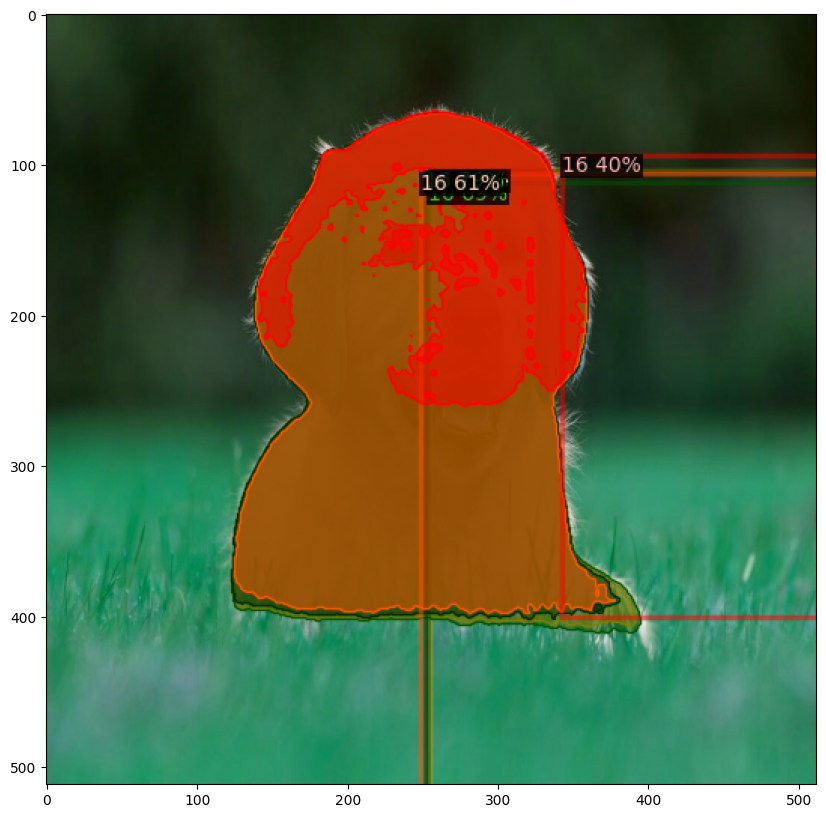

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(img)